In [396]:
from typing import Iterable
import numpy as np

import shapely.ops
import shapely.geometry as geom
import shapely.affinity as affine
import weavingspace.tiling_utils as tiling_utils
from weavingspace.tile_unit import TileUnit

import geopandas as gpd

In [784]:
def equal_tuples(t1:Iterable[float],
                 t2:Iterable[float]) -> bool:
  return np.allclose(t1, t2, atol = 1e-5)

# convenience function
def round_tuple(t):
  return tuple([np.round(x, 1) for x in t])

# Implements Knuth-Morris-Pratt see:
# https://en.wikipedia.org/wiki/Knuth–Morris–Pratt_algorithm
# but for sequences of tuples of floats
def find_matches(seq:Iterable[tuple[float]], 
                 pat:Iterable[tuple[float]],
                 equals = equal_tuples) -> list[int]:
  # print(
  #   f"""
  #   Searching for: 
  #   {[round_tuple(t) for t in pat]} in
  #   {[round_tuple(t) for t in seq]}
  #   """)
  j, k, = 0, 0
  finds = []
  table = get_table(pat)
  while j < len(seq):
    if equals(pat[k], seq[j]):
      j = j + 1
      k = k + 1
      if k == len(pat):
        finds.append(j - k)
        k = table[k]
    else:
      k = table[k]
      if k < 0:
        j = j + 1
        k = k + 1
  return finds

def get_table(pattern:Iterable,
              equals = equal_tuples) -> Iterable:
  pos = 1
  cnd = 0
  T = {0: -1}
  
  while pos < len(pattern):
    if np.allclose(pattern[pos], pattern[cnd]):
      T[pos] = T[cnd]
    else:
      T[pos] = cnd
      while cnd >= 0 and not equals(pattern[pos], pattern[cnd]):
        cnd = T[cnd]
    pos = pos + 1
    cnd = cnd + 1
  
  T[pos] = cnd
  return tuple(T.values())

In [1356]:
def get_lengths_and_angles(p:geom.Polygon) -> list[tuple[float]]:
  lengths = tiling_utils.get_edge_lengths(p)
  angles = tiling_utils.get_interior_angles(p)
  return list(zip(lengths + lengths[:1], angles + angles[:1]))

def get_edge_bearings(p:geom.Polygon) -> tuple[tuple[float]]:
  edges = tiling_utils.get_edges(p)
  return tuple([np.degrees(np.arctan2(
    e.coords[1][1] - e.coords[0][1], e.coords[1][0] - e.coords[0][0])) 
    for e in edges])


In [1313]:

# Based on
# Eades, P. 1988. Symmetry Finding Algorithms. In Machine Intelligence and 
# Pattern Recognition, ed. G. T. Toussaint, 6:41–51. Computational Morphology. 
# North-Holland. doi: 10.1016/B978-0-444-70467-2.50009-6.
# and also
# Wolter, J. D., T. C. Woo, and R. A. Volz. 1985. Optimal algorithms for 
# symmetry detection in two and three dimensions. The Visual Computer 1(1): 
# 37–48. doi: 10.1007/BF01901268.
def find_symmetries_old(p:geom.Polygon) -> tuple[tuple[float], tuple[float]]:
  encoded_polygon = get_lengths_and_angles(p)
  plain_code = encoded_polygon[:-1]
  n = len(plain_code)
  # rotations
  S = plain_code + plain_code[:-1]
  rotation_matches = find_matches(S, plain_code)
  print(f"{rotation_matches=}")
  # reflections
  reflected_code = list(reversed(encoded_polygon[1:]))
  S = reflected_code[1:] + reflected_code #list(reversed(S))
  reflection_matches = find_matches(S, reflected_code)
  print(f"{reflection_matches=}")
  reflections = []
  bearings = list(reversed(get_edge_bearings(p)))
  edge_normals = [(b + 90) % 360 - 180 for b in bearings]
  mirror_angles = []
  for i, norm in enumerate(edge_normals):
    mirror_angles.extend([
      norm, (edge_normals[i] + edge_normals[(i + 1) % n]) / 2
    ])
  mirror_angles = [a % 360 for a in mirror_angles]
  for m in reflection_matches:
    i = int(np.ceil((n + m + 1) / 2)) - 1
    # i = (n + m - 1) % n
    # print(f"{n=},{m=},{i=}")
    # reflections.append(mirror_angles[i])
    print(f"{n=},{m=},{i=},{'edge' if (n+m)%2==0 else 'corner'}")
    if (n + m) % 2 == 0:
      reflections.append(bearings[i] + 90)
    else:
      reflections.append(bearings[i] + reflected_code[i][1] / 2)
  
  return {"rotations": tuple([x / n * 360 for x in rotation_matches]),
          "reflections": tuple(reflections),
          "mirrors": mirror_angles
          }

In [1412]:

def find_symmetries(
    p:geom.Polygon) -> tuple[tuple[float], tuple[float]]:
  # get edge lengths
  lengths = tiling_utils.get_edge_lengths(p)
  # get angles
  raw_angles = tiling_utils.get_interior_angles(p)
  angles = raw_angles[1:] + raw_angles[:1]
  # encode polygon
  poly_code = list(zip(lengths, angles))
  # rotations:
  # compose characteristic string
  S = poly_code + poly_code[:-1]
  # find cyclic matches
  rotation_matches = find_matches(S, poly_code)
  # reflections:
  # encode mirrored polygon
  lengths_r = list(reversed(lengths))
  angles_r = list(reversed(raw_angles))
  poly_r_code = list(zip(lengths_r, angles_r))
  reflection_matches = find_matches(S, poly_r_code)
  # calculate rotations
  n = len(lengths)
  rotations = [i * 360 / n for i in rotation_matches]
  # calculate all possible reflection axes
  bearings = get_edge_bearings(p)
  reflection_axes = []
  for i in range(n):
    reflection_axes.append(bearings[i] - raw_angles[i] / 2)
    reflection_axes.append(bearings[i] - 90)
  reflections = [reflection_axes[i] for i in reflection_matches]
  return {"rotations": rotations,
          "reflections": reflections,
          "mirrors": round_tuple(reflection_axes)}


In [1459]:
# poly = affine.scale(tiling_utils.get_regular_polygon(1000, n = 3), 0.8, 0.9)
# poly = tiling_utils.get_regular_polygon(1000, n = 4)
poly = tiling_utils.get_regular_polygon(1000, n = 5)
# poly = TileUnit(tiling_type = "hex-dissection", n = 3).elements.geometry[0]
# poly = TileUnit(tiling_type = "hex-dissection", n = 12).elements.geometry[0]
# poly = TileUnit(tiling_type = "hex-dissection", n = 6).elements.geometry[1]
# poly = TileUnit(tiling_type = "cairo", n = 3).elements.geometry[0]
# poly = TileUnit(tiling_type = "archimedean", code = "4.8.8").elements.geometry[1]

poly = affine.translate(poly, -poly.centroid.x, -poly.centroid.y)

symmetries = find_symmetries(poly)
symmetries

{'rotations': [0.0, 72.0, 144.0, 216.0, 288.0],
 'reflections': [53.999999984564,
  17.999999969127998,
  -18.000000012639916,
  -53.99999999440783,
  -90.0],
 'mirrors': (54.0,
  18.0,
  -18.0,
  -54.0,
  -90.0,
  -126.0,
  -162.0,
  -198.0,
  126.0,
  90.0)}

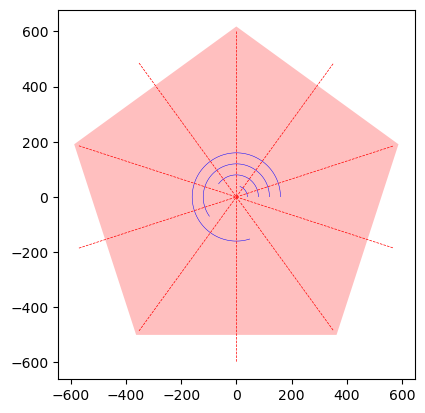

In [1472]:
ax = gpd.GeoSeries([poly]).plot(fc = "r", alpha = 0.25)

rotations = symmetries["rotations"]
s = 200 / len(rotations)
ls = []
for i, r in enumerate(rotations):
  if i > 0:
    ls.append(
      geom.LineString(
        [[s * i * np.cos(a), s * i * np.sin(a)] 
          for a in np.linspace(0, np.pi / 180 * r, 100)]))
gpd.GeoSeries(ls).plot(ax = ax, color = "b", lw = 0.35)

mirror_lines = symmetries["reflections"]
if len(mirror_lines) > 0:
  gpd.GeoSeries([affine.rotate(geom.LineString([(-600, 0), (600, 0)]), a) for a in mirror_lines]).plot(ax = ax, color = "r", ls = "dashed", lw = 0.5)
# for i, p in enumerate(poly.exterior.coords):
#   if i == 0:
#     ax.annotate(text = i, xy = p, color = "r")
  
# r = tiling_utils.get_apothem_length(poly)
# mirrors = gpd.GeoSeries(
#   [affine.rotate(geom.LineString([(-r, 0), (r, 0)]), m, (0, 0)) 
#    for m in symmetries["mirrors"]])
# mirrors.plot(ax = ax, color = "grey", lw = 0.5)
# for i, m in enumerate(mirrors):
#   p = m.interpolate(0.05, normalized = True)
#   ax.annotate(text = i, xy = (p.x, p.y))
